# PHYS3116 Tutorial 3: SQL and Scaling Relations

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## SQL

*"Structured Query Language (SQL) is a domain-specific language used in programming and designed for managing data held in a relational database management system (RDBMS), or for stream processing in a relational data stream management system (RDSMS). It is particularly useful in handling structured data, i.e., data incorporating relations among entities and variables. "* - Wikipedia

#### Code description
```sql
SELECT tells SQL which columns you are interested in selecting.
    FROM tells SQL which tables I am taking these columns from.
    JOIN tells SQL that I wish to join an additional table to the existing one.
    AS tells SQL what short name I want to refer to the imported table with.
    ON tells SQL on what basis the tables are joined
    WHERE tells SQL about the conditions under which the rows are included in the table.
```

The following query can be ran on [Data Central](https://datacentral.org.au/services/query/) to extract information regarding $v/\sigma$, age and mass of galaxies.
```sql
SELECT t1.CATID, t1.VSIGMA_RE, t1.VSIGMA_RE_ERR, t2.Age_RE, t3.Mstar 
    FROM sami_dr3.samiDR3Stelkin as t1
    JOIN sami_dr3.SSPAperturesDR3 as t2 ON t1.CATID = t2.CATID
    JOIN sami_dr3.InputCatClustersDR3 as t3 on t1.CATID = t3.CATID
    WHERE t1.VSIGMA_RE IS NOT NULL AND
    t2.Age_RE IS NOT NULL and
    t3.Mstar IS NOT NULL
```

Query below show certain features that are useful to an astronomer, such as querying around a specific region of space which is difficult to replicate with traditional SQL. 
```python
from astroquery.gaia import Gaia

# query Gaia database to select stars in the Gaia DR2 catalog 
# near (R.A, Dec.) = (0, 0)
# near the North Celestial Pole

query = """SELECT ra, dec
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
  POINT('ICRS', ra, dec),
  CIRCLE('ICRS', 0, 0, 0.25))
  AND phot_bp_mean_mag < 15
"""
```

## Tutorial

Lets us quickly learn how to merge two dataframes

The dataset's schema can be accessed using Data Central: https://datacentral.org.au/services/schema/#sami

We can merge dataframes using `pd.merge(df1, df2, on='id')`

In [227]:
kinematics = pd.read_csv('kinematics.csv')
properties = pd.read_csv('properties.csv')

In [228]:
kinematics.head()

,CATID,VSIGMA_RE,VSIGMA_RE_ERR
0,9008500296,0.567269,0.015592
1,9011900161,0.251846,0.032540
2,9011900183,0.238040,0.007821
3,9011900233,0.422081,0.004661
4,9011900383,0.545734,0.006657


In [229]:
properties.head()

,CATID,Age_RE,Mstar
0,9008500296,5.746323,10.461699
1,9011900161,4.779583,9.722659
2,9011900183,7.751576,10.439580
3,9011900233,7.751576,10.868855
4,9011900383,6.447480,10.668077


In [230]:
galaxy_properties = pd.merge(kinematics, properties, on='CATID')

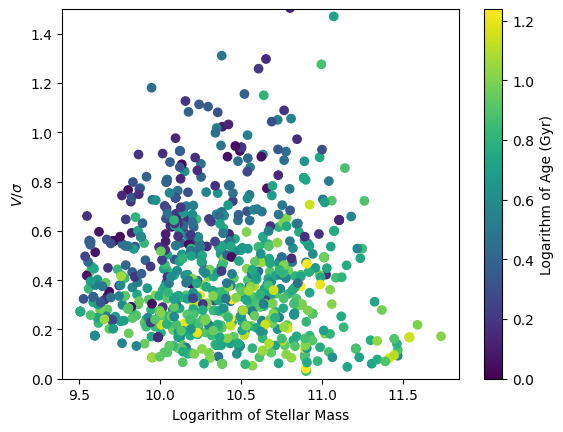

In [231]:
plt.scatter(
    galaxy_properties['Mstar'],
    galaxy_properties['VSIGMA_RE'],
    c=np.log10(galaxy_properties['Age_RE']),
)
plt.ylim(0, 1.5)
plt.xlabel('Logarithm of Stellar Mass')
plt.ylabel(r'$V/\sigma$')
cbar = plt.colorbar()
cbar.set_label('Logarithm of Age (Gyr)')

Interesting enough we can make a few dedications from this graph:
- Younger galaxies tend to be more rotationally driven while older galaxies tend to be pressure supported (as older galaxies tend to have more unordered motion $\sigma$ vs ordered motion $V$.    
- Ages seems to be loosely correlate with mass
    - An active part of research is how galaxies kinematics changer over time.
    - Do they progress from cold to hotter orbits via merging or do some galaxy start off as hotter? 
    - It is likely a combination of both and would require more research to delineate.   



# Excercises

## 1) SAMI: Galactic Chemistry and Dynamics
#### a) Import `samiDR3VisualMorphology`, `InputCatGAMADR3`, `samiDR3StelKin.csv` and `samiDR3InputCatClusters` 
#### b) Determine how many galaxies are "Early Spiral" (i.e. Type 2) within the SAMI Survey (look into `samiDR3VisualMorphology`)
#### c) Make a plot of mass vs g-i color and colour by morphological type (ignore galaxies with no morphological agreement or unsure)


Morphological Type are classified like so: 
0=E; 0.5=E/S0; 1=S0; 1.5=S0/Early-spiral; 2=Early-spiral; 2.5=Early/Late spiral; 3=Late spiral; 5=?; -9=no agreement

To investigate what property each table has, checkout [SAMI DR3 Schema Browser](https://datacentral.org.au/services/schema/#sami).

In [232]:
# 1) a)
morph = pd.read_csv('samiDR3VisualMorphology.csv')
gama = pd.read_csv('InputCatGAMADR3.csv')
stelkin = pd.read_csv('samiDR3StelKin.csv')
cluster = pd.read_csv('samiDR3InputCatClusters.csv')
# Remove index column which annoys me
morph = morph.drop(['Unnamed: 0'], axis=1)

Text(0.5, 1.0, 'Galaxy Types Histogram for SAMI')

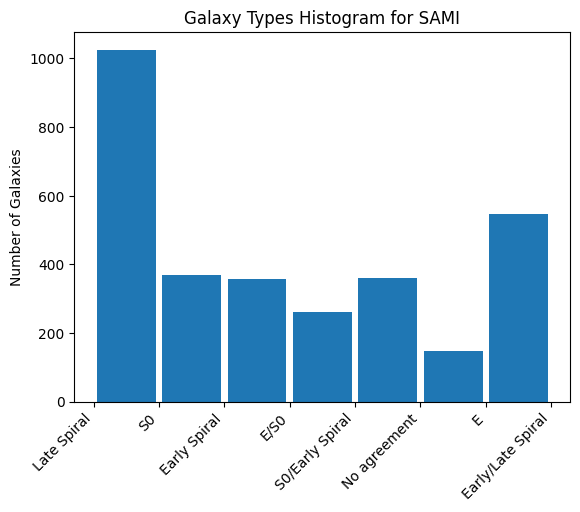

In [233]:
# 1) b)
def type_to_name(morphology_type):
    if morphology_type == 0:
        return 'E'
    elif morphology_type == 0.5:
        return 'E/S0'
    elif morphology_type == 1:
        return 'S0'
    elif morphology_type == 1.5:
        return 'S0/Early Spiral'
    elif morphology_type == 2:
        return 'Early Spiral'
    elif morphology_type == 2.5:
        return 'Early/Late Spiral'
    elif morphology_type == 3:
        return 'Late Spiral'
    else:
        return 'No agreement'

morph['type_name'] = morph['type'].apply(type_to_name)
plt.hist(morph['type_name'], rwidth=0.9, bins=7)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Galaxies')
plt.title('Galaxy Types Histogram for SAMI')

In [234]:
count = sum(morph['type'] == 2)
print(f'Number of Early Spirals is {count}')

Number of Early Spirals is 358


In [235]:
count = sum((morph['type'] == 2) | (morph['type'] == 1) | (morph['type'] == 3))
print(f'Number of Early Spirals is {count}')

Number of Early Spirals is 1753


In [237]:
# 1) c)
# lets combine morph and gamma so we can get all the details we need into a single dataframe
gamma_morph = pd.merge(gama, morph, on='catid')

In [252]:
# from above we can see that when the morphological type = -9 there is no agreement and dunno what 5 is
# let's ignore these and filter them out
gamma_morph = gamma_morph[(gamma_morph["type"] != -9) & (gamma_morph["type"] != 5)]

# also now the indexing is off so let's just also reset the indexing
gamma_morph = gamma_morph.reset_index(drop=True)

Text(0, 0.5, 'g-i [mag]')

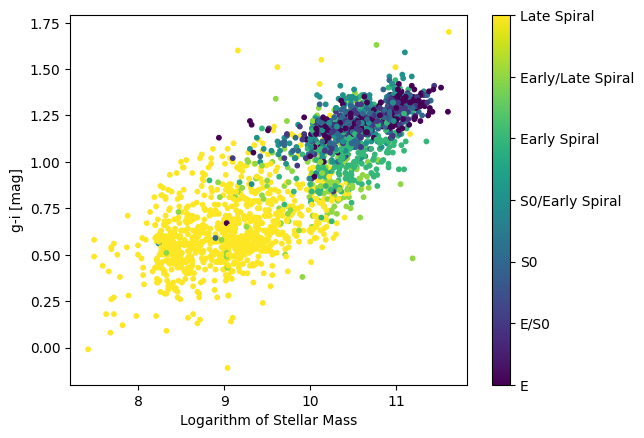

In [251]:
mstar = gamma_morph["mstar"]
morphology = gamma_morph["type"]
g_i = gamma_morph["g_i"]

sc = plt.scatter(mstar, g_i, c= morphology,vmin = 0, vmax = 3, s=10)

unique_types = np.unique(morphology)
cbar = plt.colorbar(sc, ticks=unique_types)
cbar.ax.set_yticklabels([type_to_name(m) for m in unique_types])

plt.xlabel('Logarithm of Stellar Mass')
plt.ylabel("g-i [mag]")

Higher (g-i) values → redder colors

Lower (g-i) values → bluer colors